## Mixed layer depth in ACCESS-OM2

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-paper-1/issues/38

In [1]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [2]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39801 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39801/status,
Dashboard: /proxy/39801/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44215,Workers: 0
Dashboard: /proxy/39801/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:32789,Total threads: 1
Dashboard: /proxy/34441/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41549,


### Define plot function

In [3]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [4]:
def plot(dat, title=None, **kwargs):
    if title is None:
        title = dat.attrs['long_name']
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    dat.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45)),
                     "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        **kwargs
    )
    
    # Add blue marble land:
    ax.imshow(
        blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
    )
    
    plt.title(title);

### Load and plot data from ACCESS-OM2
use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258#p-747-ryf-7

In [5]:
# exptname = '025deg_jra55_ryf9091_gadi'
exptname = '025deg_jra55_iaf_omip2_cycle1'
datastore = intake.cat.access_nri[exptname]

In [8]:
geolon = datastore.search(variable="geolon_t").to_dask().geolon_t
geolat = datastore.search(variable="geolat_t").to_dask().geolat_t

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [9]:
# for 025deg_jra55_iaf_omip2_cycle1
variable = "mld"
frequency = "1mon"  # also available daily

model_all = datastore.search(variable=variable, frequency=frequency).to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable].cf.assign_coords({ "longitude": geolon, "latitude": geolat })

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [10]:
# for IAF
model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)

In [11]:
model_all.time.values[0] # initial date in data

cftime.DatetimeProlepticGregorian(1958, 1, 14, 12, 0, 0, 0, has_year_zero=True)

In [12]:
model_all.time.values[-1] # final date in data

cftime.DatetimeProlepticGregorian(2018, 12, 14, 12, 0, 0, 0, has_year_zero=True)

In [13]:
# set time range

# timerange = slice(cftime.DatetimeNoLeap(1942, 1, 1, 0, 0, 0, 0),
#                   cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0))
# timerange = slice(None, None)
datestop = cftime.DatetimeProlepticGregorian(1987, 12, 31, 12, 0, 0, 0, has_year_zero=True) # to match OM3 IAF run
datelist = list(cftime.to_tuple(datestop))
datelist[0] -= 10  # last 10 years
datestart = cftime.datetime(*datelist, calendar=datestop.calendar)
timerange = slice(datestart, datestop)

In [14]:
datestart

cftime.datetime(1977, 12, 31, 12, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True)

In [15]:
datestop

cftime.DatetimeProlepticGregorian(1987, 12, 31, 12, 0, 0, 0, has_year_zero=True)

In [16]:
model_all = model_all.sel(time=timerange)

In [17]:
model_monthly_mean = model_all.groupby('time.month').mean('time')

In [18]:
%%time
# small BUG: mean of monthly means is not mean of days in that month (eg Feb gets slightly more heavily weighted)
model_JFM_mean = model_monthly_mean.sel(month=slice(1,3)).mean('month').load()
model_JAS_mean = model_monthly_mean.sel(month=slice(7,9)).mean('month').load()

CPU times: user 16.5 s, sys: 11.4 s, total: 27.9 s
Wall time: 2min 9s


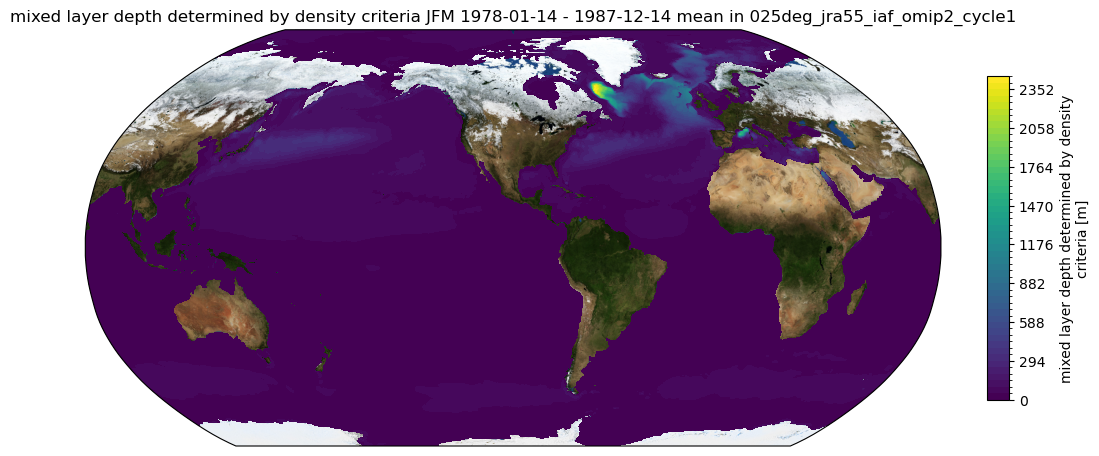

In [22]:
plot(model_JFM_mean,
    levels=51,
    vmin=0,
    vmax=None,
    # extend="max",
    cmap='viridis',
    title=f"{model_all.attrs['long_name']} JFM {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname}"
    )

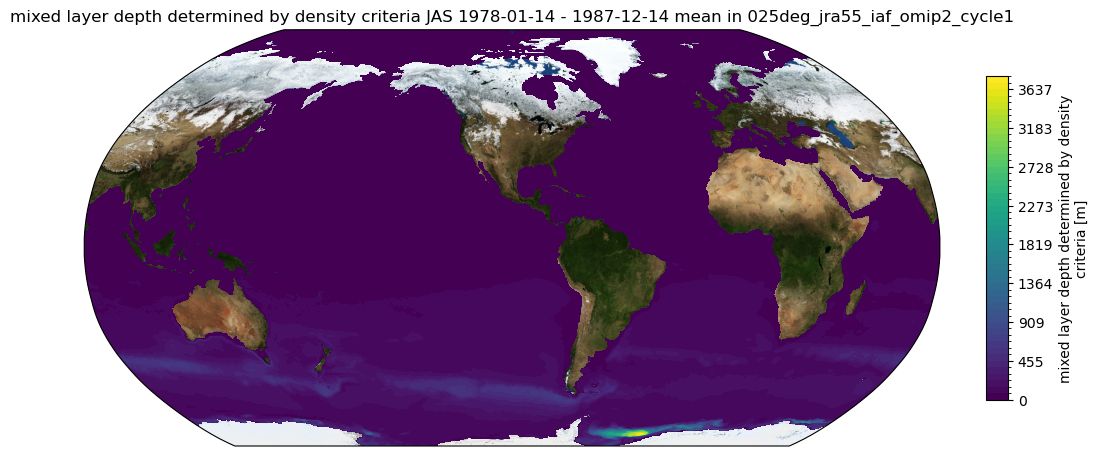

In [23]:
plot(model_JAS_mean,
    levels=51,
    vmin=0,
    vmax=None,
    # extend="max",
    cmap='viridis',
    title=f"{model_all.attrs['long_name']} JAS {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname}"
    )

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


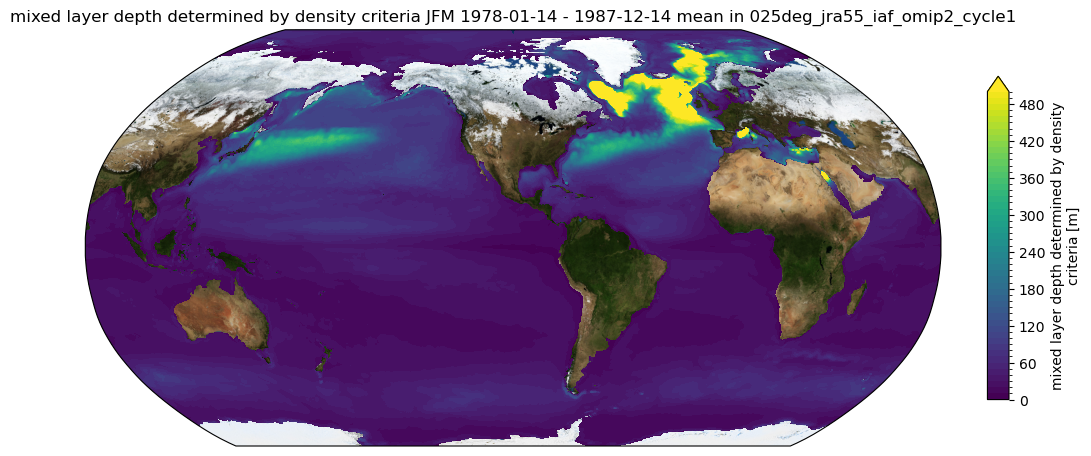

In [20]:
plot(model_JFM_mean,
    levels=51,
    vmin=0,
    vmax=500,
    extend="max",
    cmap='viridis',
    title=f"{model_all.attrs['long_name']} JFM {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname}"
    )

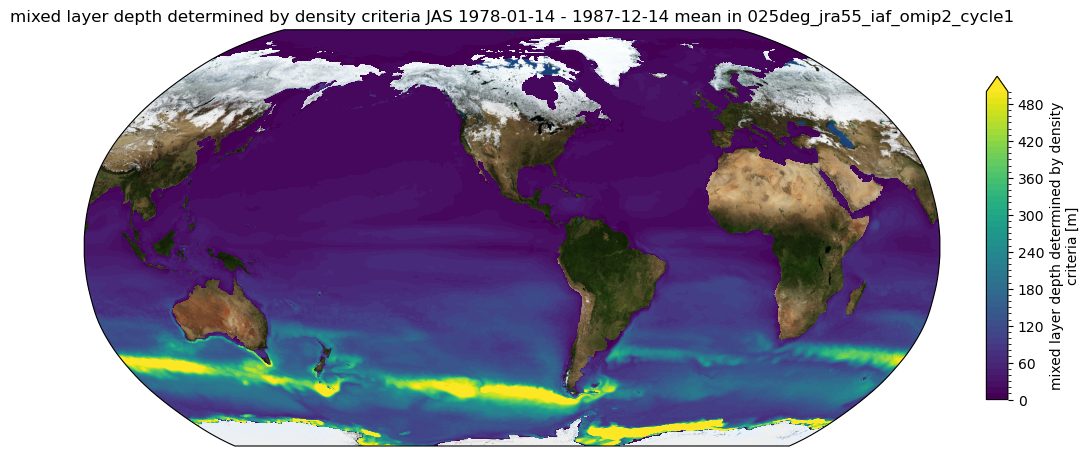

In [21]:
plot(model_JAS_mean,
    levels=51,
    vmin=0,
    vmax=500,
    extend="max",
    cmap='viridis',
    title=f"{model_all.attrs['long_name']} JAS {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname}"
    )

In [ ]:
MLDobs = xr.open_dataset('/g/data/v45/aek156/notebooks/github/ACCESS-Community-Hub/access-om3-25km-paper-1/notebooks/DeBoyerMontegut2022a/mld_dr003_ref10m_v2023.nc')['mld_dr003']
MLDobs.attrs['units'] = MLDobs.attrs['unit']  # fix so plot works

# TODO: append copy of westernmost data to eastern end to avoid gap in plot

In [ ]:
# small BUG: mean of monthly means is not mean of days in that month (eg Feb gets slightly more heavily weighted)
MLDobs_JFM_mean = MLDobs.isel(time=[0, 1, 2]).mean('time').load()
MLDobs_JAS_mean = MLDobs.isel(time=[6, 7, 8]).mean('time').load()

In [ ]:
plot(MLDobs_JFM_mean,
    levels=51,
    vmin=0,
    vmax=500,
    extend="max",
    cmap='viridis',
    title=f"Observed mixed layer depth JFM mean (DeBoyer Montegut, 2023)"
    )

In [ ]:
plot(MLDobs_JAS_mean,
    levels=51,
    vmin=0,
    vmax=500,
    extend="max",
    cmap='viridis',
    title=f"Observed mixed layer depth JAS mean (DeBoyer Montegut, 2023)"
    )

In [ ]:
client.close()